In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os,cv2

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

## Constants

In [2]:
num_clases=2
channels=3
image_resize=224
resnet_pooling_average='avg'
dense_layer_activation='softmax'
objective_function='categorical_crossentropy'
loss_metrics=['accuracy']

n_epochs=10
early_stop_patience=3

steps_per_epoch_training=10
steps_per_epoch_validation=10

batch_size_training=100
batch_size_validation=100

batch_size_testing=1

In [3]:
resnet_weights_path='../input/Data Sources/ResNet-50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
model=Sequential()

model.add(ResNet50(include_top=False,pooling=resnet_pooling_average,weights='imagenet'))
model.add(Dense(num_clases,activation=dense_layer_activation))
model.layers[0].trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
sgd=SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss=objective_function,metrics=loss_metrics)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [7]:
img_size=image_resize
data_gen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
train_generator=data_gen.flow_from_directory(
'../input/catsdogs-trainvalid-80pc-prepd/trainvalidfull4keras/trainvalidfull4keras/train',
    target_size=(img_size,img_size),
    batch_size=batch_size_training,
    class_mode='categorical'
    
)

validation_generator=data_gen.flow_from_directory(
'../input/catsdogs-trainvalid-80pc-prepd/trainvalidfull4keras/trainvalidfull4keras/valid',
    target_size=(img_size,img_size),
    batch_size=batch_size_validation,
    class_mode='categorical'
    
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [9]:
batch_size_training,len(train_generator),batch_size_validation,len(validation_generator)

(100, 200, 100, 50)

In [10]:
early_stop=EarlyStopping(monitor='val_loss',patience=early_stop_patience)
check=ModelCheckpoint(filepath='/kaggle/working/best.keras',monitor='val_loss',save_best_only=True,mode='auto')

In [11]:
history=model.fit(
                            train_generator,
                              steps_per_epoch=steps_per_epoch_training,
                              epochs=n_epochs,
                              validation_data=validation_generator,
                               validation_steps=steps_per_epoch_validation,
                                callbacks=[early_stop,check])

model.load_weights('/kaggle/working/best.keras')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8016 - loss: 0.4039 - val_accuracy: 0.9760 - val_loss: 0.0647
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9812 - loss: 0.0510 - val_accuracy: 0.9850 - val_loss: 0.0481
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 959ms/step - accuracy: 0.9869 - loss: 0.0453 - val_accuracy: 0.9890 - val_loss: 0.0356
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step - accuracy: 0.9859 - loss: 0.0358 - val_accuracy: 0.9880 - val_loss: 0.0373
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - accuracy: 0.9893 - loss: 0.0222 - val_accuracy: 0.9820 - val_loss: 0.0482
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - accuracy: 0.9861 - loss: 0.0362
Epoch 7/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9901 - loss: 0.0472 - val_accuracy: 0.9800 - val_loss: 0.0564


In [12]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

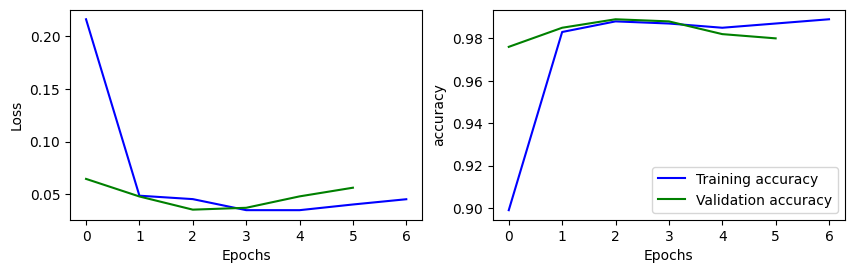

In [15]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(history.history['loss'],color='b',label='Training Loss')
plt.plot(history.history['val_loss'],color='g',label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(history.history['val_accuracy'],color='g',label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

plt.legend()
plt.show()

In [16]:
test_generator=data_gen.flow_from_directory(
   '../input/test-files-prepd/test4keras/test4keras',
    target_size=(img_size,img_size),
    batch_size=batch_size_testing,
    class_mode=None,
    shuffle=False,
    seed=123

    
)

Found 12500 images belonging to 1 classes.


In [17]:
pred=model.predict(test_generator,steps=len(test_generator),verbose=1)

pred_classes_indecies=np.argmax(pred,axis=1)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step


In [19]:
test_generator.filenames[500]

'test/10448.jpg'

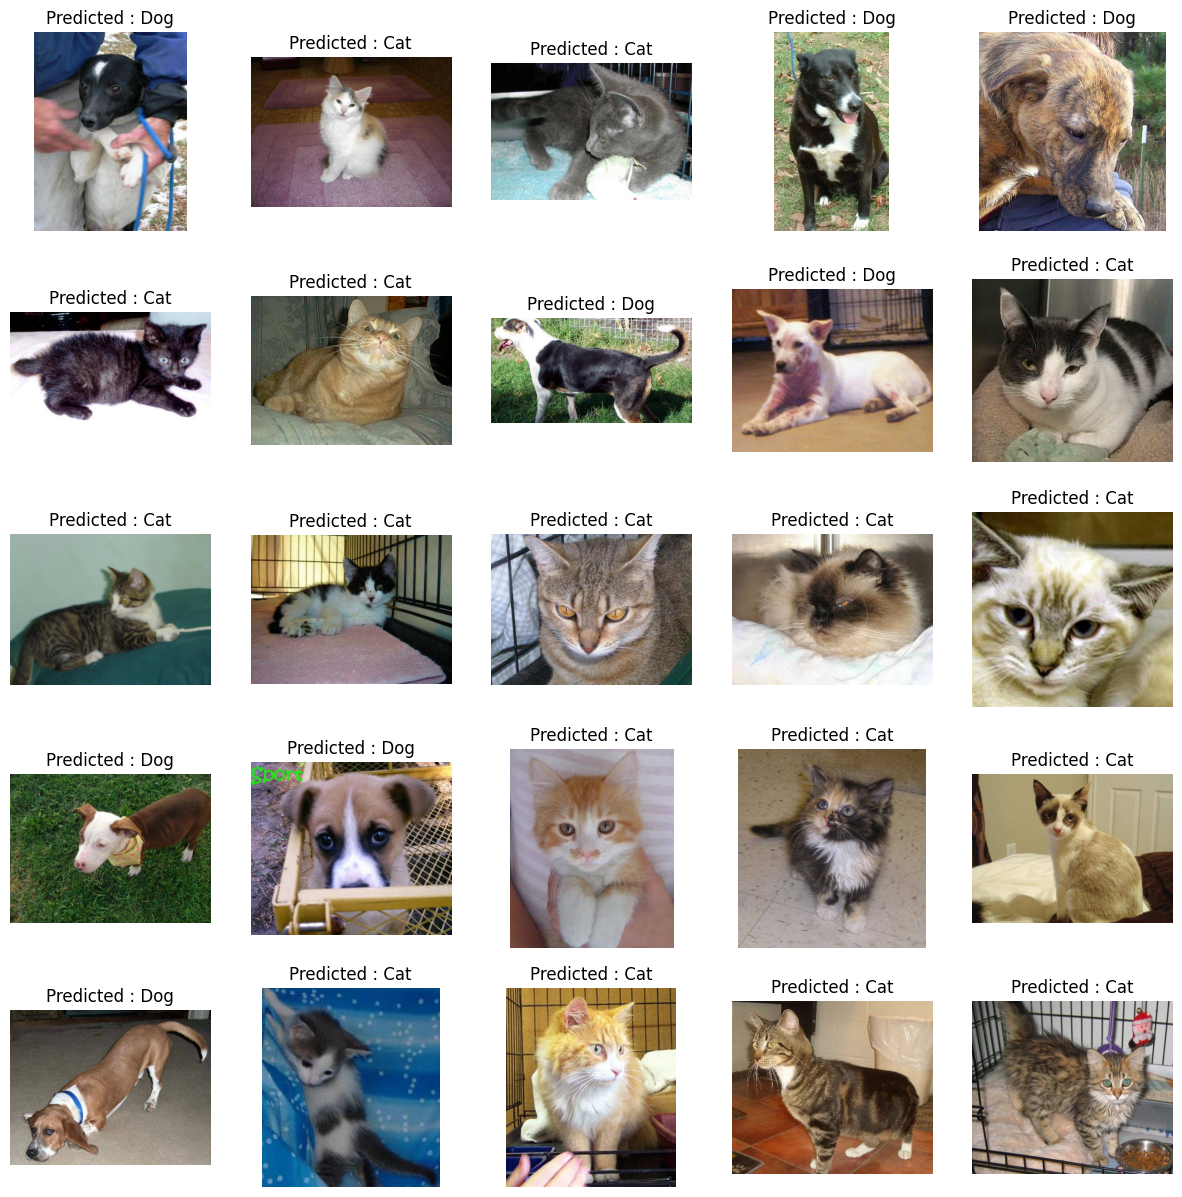

In [30]:
test_dir='../input/test-files-prepd/test4keras/test4keras/'

fig,ax=plt.subplots(5,5,figsize=(15,15))
for i in range (0,25):
    img=load_img(test_dir + test_generator.filenames[i])
    predicted_class='Dog' if pred_classes_indecies[i] else 'Cat'

    ax[i//5 , i%5].imshow(img)
    ax[i//5 , i%5].axis('off')
    ax[i//5 , i%5].set_title(f"Predicted : {predicted_class}")
   
     